## two-stream fusion论文笔记

根据文章：C.Feichtenhofer, A.Pinz, and A.isserman.Convolutional Two-Stream Network Fusion for Video Action Recognition整理。

### fusion approach
#### 1）spatial fusion（空间域的融合方法）

1、sum fusion:$y^{sum}=f^{sum}(x^a,x^b)$，即在对应的feature通道d相同的空间位置i，j中将两个feature map叠加，应该是每个元素按位直接向加，即$\mathscr{y}^{sum}_{i,j,d}=\mathscr{x}^a_{i,j,d}+\mathscr x^b_{i,j,d}$，其中$1\le i\le H,1\le j\le W,1\le d\le D\ and\ x^a,x^b,y\in \mathbb R^{H\times W\times D}$，以下类同
<br />2、max fusion:$y^{max}=f^{max}(x^a,x^b)$，应该也是按元素对应求最大值，即$\mathscr y^{max}_{i,j,d}=max\{\mathscr x^a_{i,j,d},\mathscr x^b_{i,j,d}\}$
<br />3、concatenation fusion:$y^{cat}=f^{cat}(x^a,x^b)$，按通道直接堆叠操作，即$\mathscr{y}_{i,j,2d}^{cat}=\mathscr x^a_{i,j,d},\ \mathscr y^{cat}_{i,j,2d-1}=\mathscr x^b_{i,j,d}$，融合后需要后续提出的filter来进行卷积fusion。
<br />4、conv fusion:$y^{conv}=f^{conv}(x^a,x^b)$，或写成$y^{conv}=y^{cat}\ast \mathbf f+b$，其中filter $\mathbf f \in \mathbb R^{1\times 1\times 1\times 2D\times D}\ and\ biases\ b\in \mathbb R^D$，这里f的最后一个维度指输出维度为D，这里对biases的维度有一个疑问，我感觉应该是$H\times W\times D$维度，难道这里biases共用权重每一个channels输出的元素都使用相同的biases？另外这里的卷积可以看成当在网络中用作可训练filter时，f能够学习使联合损失函数最小化的两个特征映射的对应关系。也可以看成这一过程实现了两个目的，一是实现了降维（将2D降为D），二是实现了对concatenation fusion中stack堆叠的相关性映射关系的计算。
<br />5、bilinear fusion:$y^{bil}=f^{bil}(x^a,x^b)$，即在每个像素位置计算两个特征的矩阵外积，然后对这些位置求和:$y^{bil}=\sum^H_{i=1}\sum^W_{j=1}x_{i,j}^{a\intercal}x_{i,j}^b$。此功能的主要缺点是其高维性。为了使双线性特征在实践中可用，通常在ReLU5中应用双线性特征，移除全连接层，并应用幂和L2归一化，以使用线性支持向量机进行有效分类。双线性融合的优点是一个网络的每个通道都与另一个网络的每个通道组合(作为一个输出)。然而，缺点是此时所有的空间信息都被边缘化了。

原文中对fusion操作的讨论：加入融合层会对双流网络中的参数和层的数量产生显著影响，尤其是只有融合到其中的网络被保留，而另一个网络架构被截断如图1；ReLU5处的max、sum和Conv融合(在最后一个卷积层之后)去除了架构中将近一半的参数，因为在融合之后仅使用了一个全连接层架构；与sum和max融合(97.31M)相比，Conv融合的参数略多(97.58M)，这是由于用于通道融合和降维的附加filter（就是上边提到的1*1的卷积核其中输入通道为2D输出为D）；
concatenation fusion涉及更多的参数，它没有融合后的降维，因此使第一个完全连接层中的参数数量翻倍；相比之下，softmax层的总和融合（原始的two-stream架构）需要两个流架构的所有层(16层)和参数(181.4M)。在实验部分作者评估和比较了这些可能的融合方法在分类精度方面的性能。见表1。

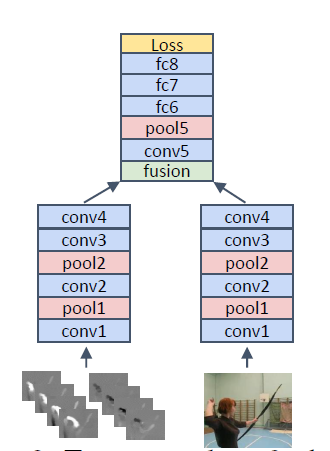

<center>图1<center/>

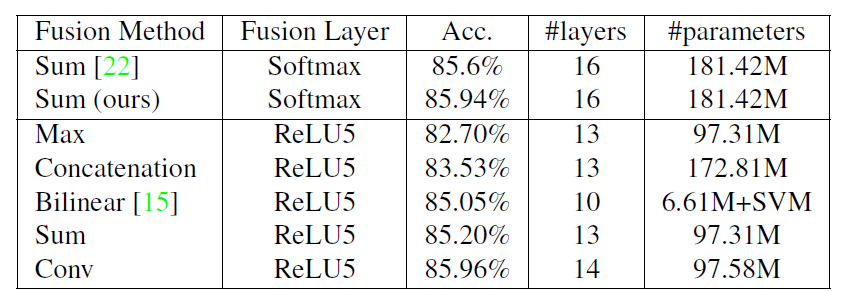

<center>表1<center/>

#### 2）Where to fuse the networks
如上所述，融合可以应用于两个网络中的任何点，唯一的限制是两个输入矩阵在时间t具有相同的维度；即$H = H^{'}，W = W^{'}$。这可以通过使用“upconvolution”layer（这里原文中的upconvolution有可能就是后来的转置卷积层即Transposed Convolution）来实现，或者如果维度相似，则可以通过用零填充较小的映射来实现上采样。通过在vgg M模型中比较，作者得出不同conv层后的融合对参数数量的影响大致相同，因为大多数参数存储在全连接层。总之越接近底层融合模型参数越少，反之越多，也可以多次融合，比如在conv5融合一次，空间tower不变，在最后与融合层再进行一次融合。作者在原文4.3节评估了不同layer融合和不同融合方式的性能。

#### 3）temporal fusion
1、2D pooling:在原始的two-stream框架中使用的是2D pooling
<br />2、3D pooling:这里作者引入了一种3D池化，用尺寸为$W^{'} \times H^{'}\times T^{'}$的3D池化层对堆叠的时域做max-pooling。这是2D pooling到时域的直接扩展。
<br />3、3D Conv + Pooling: $y=x_t\ast \mathbf f+b$，其中$\mathbf f\in \mathbb R^{H^{''}\times W^{''}\times T^{''}\times D\times D^{'}}$，filter $\mathbf f$可以对局部时空邻域中的特征的加权组合建模。三种temporal fusion的方式如下图：

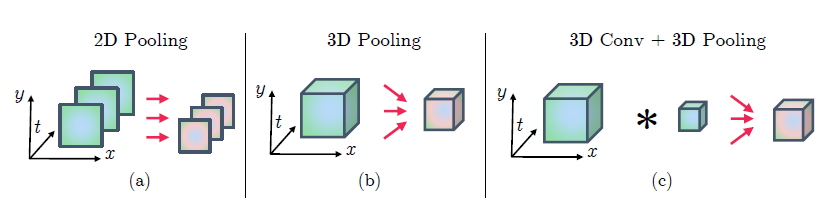

<center>图2<center/>

原文中对temporal fusion操作的讨论：作者发现有人评估了two-stream随时间推移合并两个流convnet的几种附加方法，他们发现表现最好的模型之间存在卷积层的max-pooling。作者将这里的最大池推广到3D pooling，这提供了对特征位置随时间的微小变化的不变性。此外，3D conv能学习spatio-temporal filters。例如，filter可以学习对中央时间样本进行中心加权，或在时间或空间上进行区分。

### Proposed architecture
作者提出的架构在最后一个卷积层（ReLU之后）将两个网络融合到空间流中，然后使用3D Conv融合和3D池将其转换为时空流。此外，不截断时间流，也在时间网络中执行3D池化。两条流的损失分别用于训练，在测试期间对两条流的预测进行平均。在经验评估中，表明保持两个流的性能略优于在融合后截断时间流。由于光流流具有L＝10帧的时间接收场，因此架构在T×L的总时间接收场上操作。注意，$\tau$＜L导致时间流的重叠输入，而$\tau$＞L产生时间上不重叠的特征。

### Implementation details


#### 1）双流结构：
作者使用两个预先训练过的ImageNet模型。首先，为了与原始的双流方法进行比较，使用了VGG-M-2048模型，该模型具有5个卷积层和3个全连接层。第二，使用了VGG-16模型，该模型具有13个卷积层和3个全连接层。首先按照原始双流方法中的描述分别训练这两个流，但有一些细微的区别：没有使用RGB colour jittering图像增强方式；不是按照固定的fixed schedule降低学习速率，而是在验证误差饱和后降低学习速率；为了训练空间网络，对前两个全连接层使用0.85的较低的dropout ratios。即使是较低的dropout ratios（高达0.5），也不会显著降低效果。对于时间网络，使用光流stack，L=10帧。作者还使用在ImageNet上预先训练的模型初始化了时间网络，因为与从头训练的模型相比，这通常有助于提高训练速度，而不会降低性能。预先对网络输入进行重新缩放，使帧的短边等于256。作者在训练之前预先计算光流，并将流场存储为JPEG图像（位移矢量的剪裁大于20像素）。不使用batch normalization。
<br />
#### 2）双流网络融合：
对于融合，对这些网络进行fine-tuning，批量大小为96，learning-rate从10e-3开始，一旦验证精度饱和，学习率就会降低10倍。只更新加入的融合层，因为完全的反向传播并没有带来改善（即冻结预训练的特征层）。在实验中，只在具有相同输出分辨率的层之间进行融合；除了在ReLU5_3处融合VGG-16模型和在ReLU5处融合VGG-M模型之外，用一行和一列零填充VGG-M的稍小输出（13*13，而不是14*14）。对于Conv融合，作者发现加入的融合层的初始化非常重要。比较了几种方法，发现通过单位矩阵初始化（对两个网络求和）的性能与随机初始化一样好。
<br />
#### 3）时空架构：
根据描述的最终架构，3D Conv fusion内核f的维数为3*3*3*1024*512且T=5，即时空滤波器的维数为$H^{''}*W^{''}*T^{''}=3*3*3$，Di=1024是从空间和时间流中连接ReLU5的结果，D0=512与以下FC6层的输入通道数匹配（即缩减一半的通道数）。
<br />
#### 4）3D Conv filter：
3D Conv filter也通过堆叠两个单位矩阵来初始化，以将1024个特征通道映射到512个。由于在最后一个卷积层的时间ConvNet的激活大约比其空间对应ConvNet低3倍，因此将f的时间单位矩阵初始化增加3倍。f的时空部分使用大小为$3*3*3$且σ=1的高斯函数初始化。此外，在训练期间不在预测层进行融合，因为这将使损失偏向于时间结构，因为时空结构需要更长的时间来适应融合的特征。
<br />
<br />与双流ConvNet融合相比，训练3D ConvNet更容易过拟合，并且需要额外的增强。在微调过程中，在每次训练迭代中，我们通过随机采样起始帧，然后随机采样[1,10]中的时间$stride(\tau)$，从96个视频中的每个视频中采样T=5帧（因此总共操作15到50帧）。没有裁剪固定大小的$224*224$输入图片，而是将其宽度和高度随机抖动$\pm$25%，然后将其重新缩放为$224*224$。重缩放是随机选择的，可能会改变纵横比。图片仅在距图像边界最大25%的距离（相对于宽度和高度）处裁剪。请注意，裁剪的位置（以及大小、比例、水平翻转）在第一帧（多帧堆栈）中随机选择，然后将相同的空间裁剪应用于堆栈中的所有帧。
<br />
<br />除非另有规定，与原始双流架构中的25帧相比，仅对T=5帧（及其水平翻转）进行采样，以促进快速经验评估。此外，在使用整个帧（而不是空间裁剪）的情况下，采用完全卷积测试。

### Evaluation
#### 1）How to fuse the two streams spatially?
对于实验，作者使用与原始双流中相同的网络架构，即两个VGG-M-2048网络。在整流后，在最后一个卷积层加入融合层，即其输入是来自两个流的ReLU5的输出。之所以选择此选项，是因为在初步实验中，它比conv5的非整流输出提供了更好的结果。在这一点上，这些特征已经具有很高的信息量，同时仍然提供粗略的位置信息。在融合层之后，使用单个处理流。
作者认为，ReLU5性能稍好的原因是，在这一层，外观和运动之间的空间对应被融合，这在FC层已经无法做到信息的一致性。

#### 2）Where to fuse the two streams spatially?
作者比较了不同层的融合情况。使用Conv fusion，并通过一个单位矩阵对融合层进行初始化，该单位矩阵将来自先前层的激活相加。有趣的是，在ReLU5处对一个网络进行融合和截断，在UCF101的第一个split时（85.96%对86.04%）达到与预测层（FC8）的额外融合相同的分类精度，但总参数数量要少得多（97.57M对181.68M）。

### 总结与领悟：
该文章与任务目的非常吻合，可以借鉴其中的思想，但要根据具体的任务情况做适当修改。
#### 1）数据增强：
我们的任务场景更简单（黑色背景，白色小鼠），分类目标也很简单（只是二分类），因此在数据集上过拟合的情况更容易出现，对数据集的构建更为重要，需要一定的数据增强。在训练集上我们先在中心根据窄边裁切一个最大正方形，随机裁切80%到100%的正方形这里没有进行图片比例的改变（因为我们的实验在识别中，小鼠的身长比例是一个很重要的识别因素）；随机裁切后，采用随机水平垂直翻转；进行0-90度的旋转；对图像亮度进行$\pm 10%$的增强；resize到$224*224$的尺寸；最后进行符合对imagenet与训练模型的归一化处理。
#### 2）双流融合：
在原始双流网络文章中对数据进行分类的依据是在一段视频中抽取一定的帧，然后仅对抽取的帧进行动作识别，然后将抽取的帧的输出结果做平均进行分类，最后的分类结果为该段视频的分类结果。但我们的任务需要对具体时间点做识别，因此需要对所有的数据帧做识别，因此输入模型和输出的数据量大，因此所有数据都进行双流3D ConvNet就变得不现实（抽取光流也很消耗时间），初步考虑抽取所有奇数帧进行识别（将未抽取到的帧初始化为负例，由于我们的实验数据正负例比例不均衡正例较负例多很多，最后仅需要对识别结果做填充即可，基于这种情况我们做的这种初始化），第一步仅进行对抽取的所有帧做空间域的识别对softmax值置信度不高的部分帧再进行双流融合识别。